In [1]:
%matplotlib inline

from __future__ import division
import os
import sys
from scipy import integrate, optimize

from scipy.interpolate import interp2d, interp1d

import numpy as np
from numpy import pi,sin,cos,tan,e,arctan,arcsin,arccos,sqrt
from numpy.random import randn
import matplotlib
import matplotlib.pyplot as P
from time import clock


matplotlib.rcParams['figure.figsize'] = (9, 6)
P.rcParams['text.usetex'] = True  # not really needed
P.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}'] #for \text command
P.rcParams["font.size"] = 24
P.rc('xtick', labelsize=20) 
P.rc('ytick', labelsize=20)
# P.rc('xtick', labelsize=20) 
# P.rc('ytick', labelsize=20)
np.set_printoptions(threshold=np.nan)


# sys.path.append("/Users/amadeus/Documents/10.semester/ma")
# from magmod import P_cdm_BBKS, D_z, rCom, H_0, c, H_z, E_z, Omega_m, W_tophat, T_obs, nutoz21, h
# from magmod import P_cdm_BBKS, D_z, rCom, H_0, c, H_z, E_z, Omega_m, T_obs, nutoz21, h
from magmod import *
from magbias_experiments import SKA_zhangpen, CLAR_zhangpen, SKA, cb_hirax as hirax, hirax512, LSST, LSST_nosgfit, n


sigma_8_BBKS = 0.833959881058

#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$ 
Rescaling the galaxy number density by a factor of 103811.592208 to match the gold sample with 6330073646.61 total galaxies 
#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$ 



In [2]:
#get lmin = delta_l for HIRAX and ska:

allskydegree = 4*pi*(180/pi)**2

SKAarea = SKA['S_area']
HIRAXarea = hirax['S_area']
HIRAXfov1 = 15 * (pi/180)**2
HIRAXfov2 = 56 * (pi/180)**2
HIRAXfov0 = (HIRAXfov1+HIRAXfov2)/2

print "SKa area = {}".format(SKAarea)
print "HIRAX fov = {} to {}".format(HIRAXfov1, HIRAXfov2)

lminSKA = np.int(np.around(2*pi/np.sqrt(SKAarea)))
lminHIRAX = np.int(np.around(2*pi/np.sqrt(HIRAXfov0)))
print "min ell SKA: {}, min ell HIRAX: {}".format(lminSKA,lminHIRAX)

SKa area = 5.15
HIRAX fov = 0.0045692612968 to 0.0170585755081
min ell SKA: 3, min ell HIRAX: 60


In [3]:
# plotdir = "./plots/"
# plotdir = "/Users/amadeus/Documents/PhD/work/magnification-measurements-intensity/"


lmin = 250; lmax = 30000 # lmin and lmax for Cl calculation

ltab = np.logspace(np.log10(lmin), np.log10(lmax), 25, dtype = int)


################################################
# ZhangPen:
zf = 0.75
dzf = 0.25
zfmin = zf - dzf; zfmax = zf + dzf

# zb = (1.5 + 1.9)/2
# dzb = 1.9 - zb
zb = (1.5 + 3.9)/2
dzb = 3.9 - zb
zbmin = zb - dzb; zbmax = zb + dzb
################################################



print "foreground from {} to {}".format(zfmin, zfmax)
print "background from {} to {}".format(zbmin, zbmax)



foreground from 0.5 to 1.0
background from 1.5 to 3.9


From ZiourHui:

In [4]:
# #two ways to compute the same thing:




# def Cl_delkap2_CAMB(ltable, zf, zb, delta_zf, Nint = 500, MAXMAG = False):
#     fac = bHI * (5*sg(zb) - 2)
#     return Cl_HIxmag_CAMB(ltable, zf, zb, delta_zf, Nint = Nint, MAXMAG = MAXMAG) / fac

# def Cl_delkap_CAMB(ltable, zf, zb, delta_zf, Nint = 500):
#     fac = 3/2 * (H_0/c)**2 * Omega_m
    
#     zmin = zf - delta_zf
#     zmax = zf + delta_zf
#     ztab = np.linspace(zmin, zmax, Nint) #do checks on this! should be 0 to inf
# #     gtab = [g(zz, zb, dzb) for zz in ztab] # this is slow
#     gtab = g(ztab, zb, dzb)
    
#     integrand=np.zeros([len(ztab),len(ltable)])
#     for il in range(len(ltable)):
#         ell = ltable[il]
#         integrand[:,il]= [(1+zzz) * W_tophat(zzz, zfmin, zfmax) * gtab / rCom(zzz)**2 * pknl(( ell)/rCom(zzz), zzz) for zzz in ztab]
#     result= fac * np.trapz(integrand,ztab,axis=0)
#     return result

Now we plot the number count slope:

Using non default rmax = 27 for experiment
Using non default rmax = 25 for experiment
Using non default rmax = 24 for experiment


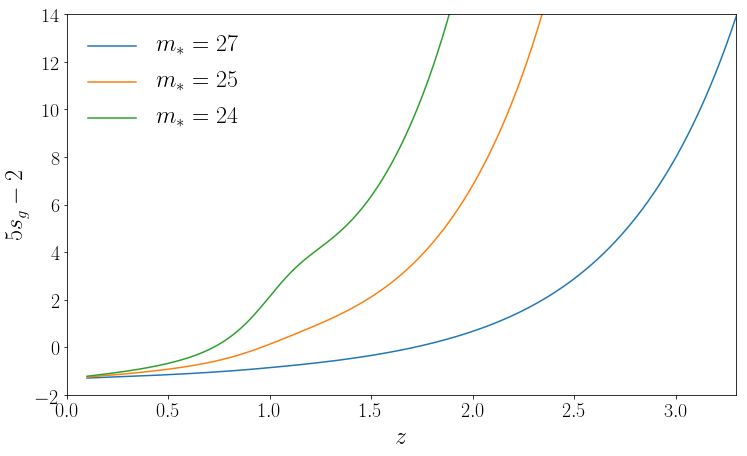

In [5]:
#now plot s :

#different z's to make plot nicer
z = np.linspace(0.1, 3.5, 500)
z2 = np.linspace(0.1, 2.5, 500)
z3 = np.linspace(0.1, 2., 500)


# Ftab = nsig * Ssys(z, CLAR_zhangpen)
# mtab = -2.5 * np.log10(Ftab)

rmax_default = 27 #for LSST
rmax2 = 25
rmax3 = 24
fig = P.figure(figsize = (12,7));
ax2 = fig.add_subplot(111)

sg1tab = 5*sg(z, MAXMAG = rmax_default)-2
sg2tab = 5*sg(z2, MAXMAG = rmax2 )-2
sg3tab = 5*sg(z3, MAXMAG = rmax3 )-2

# #TESTING THE INTERPOLATION FUNCTION:
# sg1tab = 5*sg_interp(z, MAXMAG = rmax_default)-2
# sg2tab = 5*sg_interp(z2, MAXMAG = rmax2 )-2
# sg3tab = sg5minus2(z3, rmax3 )



ax2.plot(z, sg1tab, label = r"$m_* = {}$".format(rmax_default))
ax2.plot(z2, sg2tab, label = r"$m_* = {}$".format(rmax2))
ax2.plot(z3, sg3tab, label = r"$m_* = {}$".format(rmax3))




ax2.set_xlabel(r"$z$")
ax2.set_ylabel(r"$5s_g-2$")
ax2.set_ylim((-2, 14))
ax2.set_xlim((0,3.3))


P.legend(frameon = False)
# plotdir = "/Users/amadeus/Documents/PhD/Thesis/tex/images/"
# print "we are saving plot to thesis!!!!"

plotdir = "/Users/amadeus/Documents/PhD/work/MagBias/plots/"
# P.savefig(plotdir + "alpha.pdf")

Now we calculate the galaxy power spectrum and magnification signal:

In [6]:
#Calculate the HI X mag power spectrum Cls:
rmaxtab = [23, 25, 27]
Cl_Hxm_tab = [Cl_HIxmag_CAMB(ltab, zf, dzf, zb, dzb, MAXMAG = rrr) 
                            for rrr in rmaxtab]

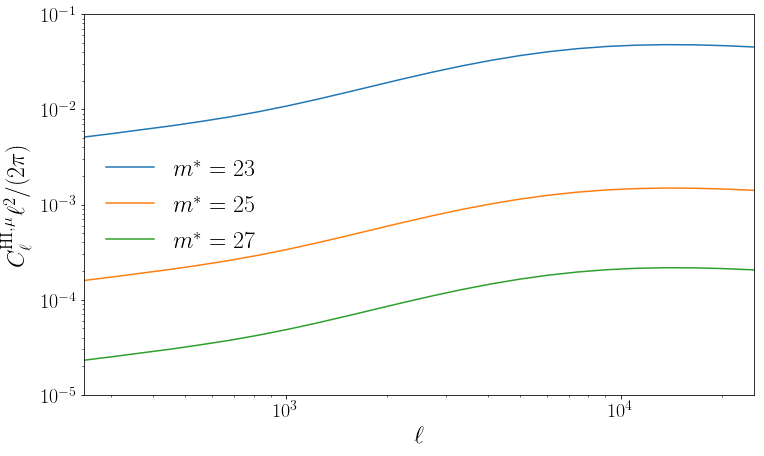

In [7]:
#plot it:
fig = P.figure(figsize = (12,7)); ax = fig.add_subplot(111);

for ri in range(len(rmaxtab)):
    rma = rmaxtab[ri]
    Clll = Cl_Hxm_tab[ri]
    ax.loglog(ltab, Clll*ltab**2 / 2 / pi, label = "$m^*={}$".format(rma))


ax.set_xlabel("$\ell$")
ax.set_ylabel("$C_\ell^\mathrm{HI, \mu} \ell^2/(2\pi)$")

ax.set_xlim((250,25000))
ax.set_ylim((1e-5, 1e-1))
# ax.set_ylim((1e-6, 6e-1))
# ax.legend()
# P.tight_layout()

P.legend(frameon = False)
# P.savefig(plotdir + "HIxmag_Cls.pdf")



In Z&P the $\ell$ dependece is $C_\ell^{\mu g} \sim \Delta_m^2(\ell/r(z_f), z_f) / l^3$.

For us it's $C_\ell^\mathrm{HI, mag} \sim P((\ell + 1/2)/r(z),z))$.

NOW: signal to noise!!! an example, same foreground redshift bin for HIRAX and SKA:

In [72]:
#set the magnitude range:
magmax = 27;
magmin = 19;

#make ell table:


lend = 2200;



#full:
ltabH = np.arange(lminHIRAX, lend + lminHIRAX, lminHIRAX)
ltabSKA = np.arange(lminSKA, lend + lminSKA, lminSKA)
# #test:
# ltabH = np.arange(lminHIRAX*10, lend + lminHIRAX, lminHIRAX*10)
# ltabSKA = np.arange(lminSKA*10, lend + lminSKA, lminSKA*10)


# lN = len(ltab)
lNH = len(ltabH)
lNSKA = len(ltabSKA)
p_func_list = [C_l_HIHI_CAMB, C_l_gg_CAMB, Cl_HIxmag_CAMB]


In [9]:
# #check the different interferometer noises:

# Nell2 = Cl_interferom_noise_slow(ltab, zf -dzf, zf + dzf, hirax)
# Nell1 = Cl_interferom_noise(ltab, zf - dzf, zf + dzf, hirax)

# fig = P.figure(); ax = fig.add_subplot(111);
# # ax.loglog(ltab, Nell1)
# # ax.loglog(ltab, Nell2, ls = "--")
# ax.semilogx(ltab, Nell2/Nell1)
# ax.set_ylim((0.8,2))
# ax.set_xlabel(r"$\ell$")
# ax.set_ylabel("old noise / new noise")
# P.savefig(plotdir + "noisetest.pdf")

In [10]:
# #without shot noise:
# S2N_SKA = S2N(ltab, zf, dzf, zb, dzb, powspeclist, SURVEY=SKA, MAXMAG = rmax_default)
# S2N_HIRAX = S2N(ltab, zf, dzf, zb, dzb, powspeclist, SURVEY=hirax, MAXMAG = rmax_default)
# # S2N_HIRAX512 = S2N(ltab, zf, dzf, zb, dzb, powspeclist, SURVEY=hirax512, MAXMAG = rmax_default)
# S2N_CV = S2N(ltab, zf, dzf, zb, dzb, powspeclist, SURVEY="CV", MAXMAG = rmax_default)

In [11]:
# #with shot noise:
# S2N_SKA_LSST = S2N(ltab, zf, dzf, zb, dzb, powspeclist, SURVEY=[SKA, LSST], MAXMAG = rmax_default)
# S2N_HIRAX_LSST = S2N(ltab, zf, dzf, zb, dzb, powspeclist, SURVEY=[hirax, LSST], MAXMAG = rmax_default)
# # S2N_HIRAX512_LSST = S2N(ltab, zf, dzf, zb, dzb, powspeclist, SURVEY=[hirax512, LSST], MAXMAG = rmax_default)

In [12]:
# fig = P.figure(figsize = (12,8)); ax1 = fig.add_subplot(111); 

# ax1.semilogx(ltab, S2N_CV, label = r"CV $\times$ CV", color = "grey")
# ax1.semilogx(ltab, S2N_SKA, label = r"SKA $\times$ CV", color = "black")
# ax1.semilogx(ltab, S2N_HIRAX, label = r"HIRAX $\times$ CV", color = "red")

# ax1.semilogx(ltab, S2N_SKA_LSST, label = r"SKA $\times$ LSST", color = "black", ls = "-.")
# ax1.semilogx(ltab, S2N_HIRAX_LSST, label = r"HIRAX $\times$ LSST", color = "red", ls = "-.")
# # ax1.semilogx(ltab, S2N_SKA_LSST, color = "black", ls = "-.")
# # ax1.semilogx(ltab, S2N_HIRAX_LSST, color = "red", ls = "-.")

# ax1.set_ylabel("$C_\ell^{HI,\mu} / \Delta C_\ell^{HI,\mu} $")
# ax1.set_xlabel("$\ell$")
# ax1.legend(loc = "upper left", fontsize = 18)

# ax1.set_ylim((0.1,1.1 * np.nanmax((S2N_HIRAX, S2N_SKA))))
# ax1.set_xlim((7e0, 5e3))

# # plotdir = "/Users/amadeus/Documents/PhD/Thesis/tex/images/"
# # print "we are saving plot to thesis!!!!"
# # P.savefig(plotdir + "S2N.pdf")

Now we use different redshift bins for HIRAX and SKA. For SKA we use B1 and B2, for HIRAX we make smaller bins, but still wider bins than would be used in a real analysis...
In the plot above the S2N for HIRAX is clearly shot noise dominated.

# setting up HIRAX redshift bins:

In [13]:
# ########################################################################
# ########################################################################
# ############WORKING ON HIRAX:####################################



# buffer_z = 0.1 #buffer between fg and bg to avoid correlation, 
# #we should pick a value more carefully later, according to photo-z measurements

# # zbbmax = 3.9 #maximum range of LSST


# ########################################################################
# ########################################################################
# ############MAKING HIRAX REDSHIFT BINS:####################################
# ########################################################################
# ########################################################################

# numax_HIRAX = hirax["survey_numax"] #800
# numin_HIRAX = numax_HIRAX - hirax['survey_dnutot'] # 400

# zHIRAX_min = nutoz21(numax_HIRAX) # minimum of HIRAX
# # zHIRAX_max = nutoz21(400) # maximum of HIRAX
# zHIRAX_max = 2. # maximum of HIRAX, more does not make sense otherwise we have no galaxies left to cross correlate with
# # dzHIRAX = 0.05
# dzHIRAX = 0.2
# # dzHIRAX = 0.15
# Nstep_H = np.int((zHIRAX_max - zHIRAX_min) / (dzHIRAX))
# print "HIRAX' z range: {} to {}".format(zHIRAX_min, zHIRAX_max)
# print "HIRAX has {} bins".format(Nstep_H)
# zHIRAX_allbin, steplen = np.linspace(zHIRAX_min, zHIRAX_max, Nstep_H, retstep = True) #lower bin edges
# zHIRAX_lowbin = zHIRAX_allbin[:-1]
# dzHIRAX = steplen
# zHIRAX_meanbin = zHIRAX_lowbin + dzHIRAX
# zHIRAX_highbin = zHIRAX_lowbin + 2*dzHIRAX
# nbinH = len(zHIRAX_lowbin)


# print dzHIRAX


In [14]:
########################################################################
########################################################################
############WORKING ON HIRAX:####################################



buffer_z = 0.1 #buffer between fg and bg to avoid correlation, 
#we should pick a value more carefully later, according to photo-z measurements

# dz = 0.25 #bin width for HIRAX and SKA
dz = 0.5 #bin width for HIRAX and SKA


########################################################################
########################################################################
############MAKING HIRAX REDSHIFT BINS:####################################
########################################################################
########################################################################

numax_HIRAX = hirax["survey_numax"] #800
numin_HIRAX = numax_HIRAX - hirax['survey_dnutot'] # 400

zHIRAX_min = nutoz21(numax_HIRAX) # minimum of HIRAX
# zHIRAX_max = nutoz21(numin_HIRAX) # maximum of HIRAX
zHIRAX_max = 2. # last bin goes slightly beyond that. more does not make sense otherwise we have no galaxies left to cross correlate with

print zHIRAX_max, zHIRAX_min
zHIRAX_allbin = np.arange( zHIRAX_min, zHIRAX_max + dz, step = dz)
print zHIRAX_allbin, "all"
zHIRAX_lowbin = zHIRAX_allbin[:-1]
zHIRAX_highbin = zHIRAX_allbin[1:]
zHIRAX_meanbin = (zHIRAX_lowbin + zHIRAX_highbin)/2

nbinH = len(zHIRAX_lowbin)
print zHIRAX_lowbin, "low"
print zHIRAX_highbin, "high"
print zHIRAX_meanbin, "mean"
print nbinH




2.0 0.7755075
[0.7755075 1.2755075 1.7755075 2.2755075] all
[0.7755075 1.2755075 1.7755075] low
[1.2755075 1.7755075 2.2755075] high
[1.0255075 1.5255075 2.0255075] mean
3


# Optimization of m* for each HIRAX redshift bin

In [15]:
########################################################################
########################################################################
# optimize S2N(m*) FOR HIRAX

ltab_HIRAX_opt = np.array([200]) #only one ell for opt

# mstar_H = np.zeros(nbinH)
opti_H = []
guesses = 25 * np.ones(nbinH)
for iz in range(nbinH):
    S2Nargs = (ltab_HIRAX_opt, zHIRAX_lowbin[iz], zHIRAX_highbin[iz], buffer_z, [hirax, LSST], [C_l_HIHI_CAMB, C_l_gg_CAMB, Cl_HIxmag_CAMB])
    opti = optimize.minimize( S2N_for_opt, [guesses[iz]], args = S2Nargs, method='Nelder-Mead', tol = 1e-2, bounds = ((magmin,magmax),))
    opti_H.append(opti)

mso_H = [oo['x'] for oo in opti_H] #m star opt = mso


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/optimize/_minimize.py:518: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
ca

In [16]:
print mso_H

[array([23.17382812]), array([26.09375]), array([26.9921875])]


# Now calculate the S2N for each HIRAX bin and the respective m*

In [17]:
########################################################################
########################################################################
# CALCULATE S2N FOR HIRAX
S2Nlist_full = [] #1024 dishes HIRAX
S2Nlist_512 = [] #512 dishes HIRAX

# ellNL = [] #nonlinear scale according to smith et a. with knl0 = 0.14



for i in range(nbinH):


#     zbbmax_H = zmax_of_MAXMAG(mso_H[i]) #max redshift for optimized m*

    zbmin_H, zbmax_H, zb_H, dzb_H = get_bg_bin_for_fgzmax(zHIRAX_highbin[i], bufferz = buffer_z)

    
#     k_NL = 0.14*(1+zb_H)#background redshift is relevant
#     ellNL.append(k_NL * rCom(zb_H))
    
    
    S2Nlist_full.append( S2N_of_mstar_and_zf(mso_H[i], ltabH, zHIRAX_lowbin[i], zHIRAX_highbin[i], 
                                             SURVEY = [hirax, LSST], bufferz = buffer_z))
    
    S2Nlist_512.append( S2N_of_mstar_and_zf(mso_H[i], ltabH, zHIRAX_lowbin[i], zHIRAX_highbin[i], 
                                             SURVEY = [hirax512, LSST], bufferz = buffer_z))


we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...


# SKA b1 and b2 redshift bins

In [18]:
########################################################################
########################################################################
############SETTING UP SKA B1 & 2:####################################

#fg:
# numin_SKA = 350 #MHz
# numax_SKA = 1750.           # Max. freq. of survey
# nutot_SKA = numax_SKA - numin_SKA

zSKA_min = 0.0005 #nutoz21(numax_SKA) # minimum of HIRAX

zSKA_max = zHIRAX_max # last bin goes slightly beyond that. more does not make sense otherwise we have no galaxies left to cross correlate with


print zSKA_max, zSKA_min

zSKA_allbin = np.arange( zSKA_min, zSKA_max + dz, step = dz)
print zSKA_allbin, "all"
zSKA_lowbin = zSKA_allbin[:-1]
zSKA_highbin = zSKA_allbin[1:]
zSKA_meanbin = (zSKA_lowbin + zSKA_highbin)/2

nbinS = len(zSKA_lowbin)
print zSKA_lowbin, "low"
print zSKA_highbin, "high"
print zSKA_meanbin, "mean"
print nbinS



2.0 0.0005
[5.0000e-04 5.0050e-01 1.0005e+00 1.5005e+00 2.0005e+00] all
[5.0000e-04 5.0050e-01 1.0005e+00 1.5005e+00] low
[0.5005 1.0005 1.5005 2.0005] high
[0.2505 0.7505 1.2505 1.7505] mean
4


In [19]:
# ########################################################################
# ########################################################################
# ############SETTING UP SKA B1:####################################




# #fg:
# b1_numin = 350 #MHz
# b1_numax= 1050.           # Max. freq. of survey
# b1_nutot= b1_numax - b1_numin

# zmin_b1, zmax_b1, zf_b1, dzf_b1 = get_fg_bin_for_frequency_range(b1_nutot, b1_numax)
# zmax_b1 = 2. #don't go beyond z=2 for shot noise reasons...




# ############SETTING UP SKA B2:####################################
# ########################################################################
# #######################################################################




# #fg:
# b2_numin = 950. #MHz
# b2_numax= 1750. #1420.        # Max. freq. of survey
# b2_nutot= b2_numax - b2_numin #470.          # Total bandwidth of *entire* survey [MHz]


# zmin_b2, zmax_b2, zf_b2, dzf_b2 = get_fg_bin_for_frequency_range(b2_nutot, b2_numax)

# print "b1 dz {}, b2 dz {}, overlap dz {}".format(zmax_b1-zmin_b1, zmax_b2 - zmin_b2, zmax_b2 - zmin_b1)
# print "b2 zmax {}, b1 zmin {}".format(zmax_b2, zmin_b1)

# SKA optimization for m*

In [20]:
 ############OPTIMIZE SKA B1 AND B2:####################################
########################################################################
#######################################################################  

ltab_SKA_opt = np.array([100]) #only one ell for opt

opti_SKA = []
guessesSKA = 21 * np.ones(nbinS)
for iz in range(nbinS):
    S2Nargs = (ltab_SKA_opt, zSKA_lowbin[iz], zSKA_highbin[iz], buffer_z, [SKA, LSST], [C_l_HIHI_CAMB, C_l_gg_CAMB, Cl_HIxmag_CAMB])
    opti = optimize.minimize( S2N_for_opt, [guessesSKA[iz]], args = S2Nargs, method='Nelder-Mead', tol = 1e-2, bounds = ((magmin,magmax),))
    opti_SKA.append(opti)

mso_SKA = [oo['x'] for oo in opti_SKA] #m star opt = mso

print mso_SKA


we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
ca

magmod.py:1051: RuntimeWarning: invalid value encountered in true_divide
  return dnndz / np.trapz(dnndz, z)


we assume d_ell = 1
shot noise for LSST!


magmod.py:999: RuntimeWarning: divide by zero encountered in double_scalars
  return 4*pi/Nz #shot noise! The 4 pi could be cancelled but this way I can check more easily that it's correct...


calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noi

In [21]:
print mso_SKA


[array([21.04921875]), array([22.91953125]), array([24.1171875]), array([26.775])]


In [22]:
#  ############OPTIMIZE SKA B1 AND B2:####################################
# ########################################################################
# #######################################################################  
    
    
    
# ltab_SKA_opt = np.array([100]) #only one ell for opt

# opti_SKA = []
# guess_b1 = 24

# guess_b2 = 20

# S2Nargs_b1 = (ltab_SKA_opt, zmin_b1, zmax_b1, buffer_z, [SKA, LSST], [C_l_HIHI_CAMB, C_l_gg_CAMB, Cl_HIxmag_CAMB])
# opti_b1 = optimize.minimize( S2N_for_opt, guess_b1, args = S2Nargs_b1, method='Nelder-Mead', tol = 1e-2, bounds = ((magmin,magmax),))

# S2Nargs_b2 = (ltab_SKA_opt, zmin_b2, zmax_b2, buffer_z, [SKA, LSST], [C_l_HIHI_CAMB, C_l_gg_CAMB, Cl_HIxmag_CAMB])
# opti_b2 = optimize.minimize( S2N_for_opt, guess_b2, args = S2Nargs_b2, method='Nelder-Mead', tol = 1e-2, bounds = ((magmin,magmax),))

    
# mso_b1 = opti_b1['x'] #m star opt = mso
# mso_b2 = opti_b2['x'] #m star opt = mso

# print mso_b1, mso_b2

# now use the optimized m* for S2N for SKA

In [23]:
########################################################################
########################################################################
# CALCULATE S2N FOR SKA
S2Nlist_SKA = []

ellNL = [] #nonlinear scale according to smith et a. with knl0 = 0.14



for i in range(nbinS):



    zbmin_S, zbmax_S, zb_S, dzb_S = get_bg_bin_for_fgzmax(zSKA_highbin[i], bufferz = buffer_z)

    
    k_NL = 0.14*(1+zb_S)#background redshift is relevant
    ellNL.append(k_NL * rCom(zb_S))
    
    
    S2Nlist_SKA.append( S2N_of_mstar_and_zf(mso_SKA[i], ltabSKA, zSKA_lowbin[i], zSKA_highbin[i], 
                                             SURVEY = [SKA, LSST], bufferz = buffer_z))


we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise


magmod.py:837: RuntimeWarning: overflow encountered in exp
  oneover_W_ell = np.exp( ltab**2 * sigb**2) #beam smoothing function.


we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise


In [24]:

# #######NOW CALCULATE S2N FOR SKA


# #bg:
# # zbbmax_b2 = zmax_of_MAXMAG(mso_b2)
# zbmin_b2, zbmax_b2, zb_b2, dzb_b2 = get_bg_bin_for_fgzmax(zmax_b2, mso_b2, bufferz = buffer_z)


# S2N_SKAb1_LSST = S2N_of_mstar_and_zf(mso_b1, ltabSKA, zmin_b1, zmax_b1, bufferz = buffer_z)
# S2N_SKAb2_LSST = S2N_of_mstar_and_zf(mso_b2, ltabSKA, zmin_b2, zmax_b2, bufferz = buffer_z)

# S2N_CV_b1 = S2N_of_mstar_and_zf(mso_b1, ltabSKA, zmin_b1, zmax_b1, bufferz = buffer_z, SURVEY = "CV")
# S2N_CV_b2 = S2N_of_mstar_and_zf(mso_b2, ltabSKA, zmin_b2, zmax_b2, bufferz = buffer_z, SURVEY = "CV")



# before plotting the S2N we show the optimization of m*:

In [25]:
#MAKE NICE PLOT FOR S2N(m*) for SKA and HIRAX:
magtab = np.linspace(magmin,magmax,50) #an example...
# magtab = np.linspace(magmin,magmax,5) #quick check...


########################################################################
########################################################################
# FOR HIRAX
ltab_HIRAX = np.array([200,500,1000]) #only few ells to speed up



S2N_H = np.zeros((len(magtab), nbinH, len(ltab_HIRAX)))

for im in range(len(magtab)): #magnitude cutoff
    for iz in range(nbinH): #redshift bin of HIRAX
        mm = magtab[im]
        S2N_H_now = S2N_of_mstar_and_zf(mm, ltab_HIRAX, zHIRAX_lowbin[iz], zHIRAX_highbin[iz],
                                        SURVEY = [hirax, LSST], bufferz = buffer_z)
        S2N_H[im,iz,:] = S2N_H_now


########################################################################
########################################################################
# FOR SKA



ltab_SKA = np.array([20,40,80]) #only few ells to speed up


S2N_S = np.zeros((len(magtab), nbinS, len(ltab_SKA)))

for im in range(len(magtab)): #magnitude cutoff
    for iz in range(nbinS): #redshift bin of SKA
        mm = magtab[im]
        S2N_S_now = S2N_of_mstar_and_zf(mm, ltab_SKA, zSKA_lowbin[iz], zSKA_highbin[iz],
                                        SURVEY = [SKA, LSST], bufferz = buffer_z)
        S2N_S[im,iz,:] = S2N_S_now


# for im in range(len(magtab)):
#     mm = magtab[im]
#     print "working with maxmag {}".format(mm)


#     S2N_b1_now = S2N_of_mstar_and_zf(mm, ltab_SKA, zmin_b1, zmax_b1, bufferz = buffer_z)
#     S2N_b2_now = S2N_of_mstar_and_zf(mm, ltab_SKA, zmin_b2, zmax_b2, bufferz = buffer_z)
    
#     SKA_b1_LSST_maxmag_arr[im,:] = S2N_b1_now
#     SKA_b2_LSST_maxmag_arr[im,:] = S2N_b2_now
    

#


we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...

magmod.py:999: RuntimeWarning: overflow encountered in double_scalars
  return 4*pi/Nz #shot noise! The 4 pi could be cancelled but this way I can check more easily that it's correct...


calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!

we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrela

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
ca

calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noi

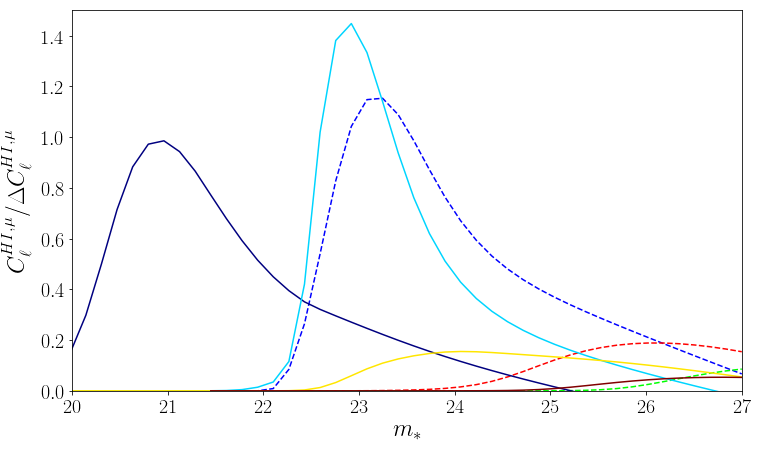

In [61]:
#MAKE NICE PLOT FOR S2N(m*) for SKA:

#colors for HIRAX and SKA:
color_array_HIRAX = np.linspace(0,1, nbinH)#+1 because we do not want the grey in set1
color_array_SKA = np.linspace(0,1,nbinS) #same for now, changed later!




cols = ["blue", "purple", "red"]

fig = P.figure(figsize = (12,7)); ax = fig.add_subplot(111);

# ax.plot(magtab, SKA_b1_LSST_maxmag_arr[:,2], c='grey', ls = "--", label = r"$\mathrm{SKA~b1}$")

# ax.plot(magtab, SKA_b2_LSST_maxmag_arr[:,2], c='black', ls = "--", label = r"$\mathrm{SKA~b2}$")


# ax.axvline(mso_b1, c = 'grey')
# ax.axvline(mso_b2, c= 'black')




for iz in range(nbinH):
    ci = color_array_HIRAX[iz]
    zfmax_now = np.around(zHIRAX_highbin[iz],2)
    zfmin_now = np.around(zHIRAX_lowbin[iz],2)
    for ielll in [0]:


        ax.plot(magtab, S2N_H[:,iz,ielll], c=P.cm.brg(ci), ls = "--", 
                label = r"$\mathrm{{~HIRAX~}} z_\mathrm{{f}} = {} \mathrm{{~to~}} {}$".format(zfmin_now, zfmax_now))
#     ax.axvline( mso_H[iz], c=P.cm.Set1(ci))

for iz in range(nbinS):
    ci = color_array_SKA[iz]
    zfmax_now = np.around(zSKA_highbin[iz],2)
    zfmin_now = np.around(zSKA_lowbin[iz],2)
    for ielll in [0]:
        ax.plot(magtab, S2N_S[:,iz,ielll], c=P.cm.jet(ci), ls = "-", 
                label = r"$\mathrm{{~SKA~}} z_\mathrm{{f}} = {} \mathrm{{~to~}} {}$".format(zfmin_now, zfmax_now))




# ax.legend(frameon = False)
ax.set_xlabel(r"$m_*$")
ax.set_ylabel("$C_\ell^{HI,\mu} / \Delta C_\ell^{HI,\mu} $")
ax.set_ylim((0,1.5))
ax.set_xlim((20,27))

# plotdir = "./plots/"
# print plotdir
# P.savefig(plotdir + "S2N_of_mstar.pdf")

# main plot S2N:

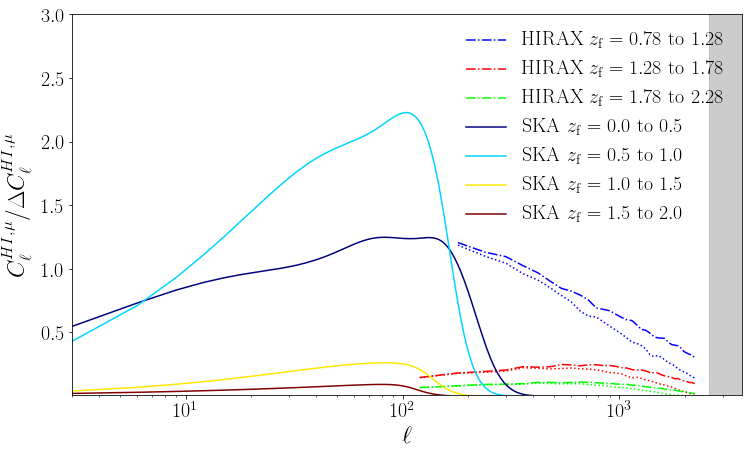

In [60]:
#plotting HIRAX and SKA for different binnings:

fig = P.figure(figsize = (12,7)); ax1 = fig.add_subplot(111); 



for i in range(nbinH):
    ci = color_array_HIRAX[i]
    zfmax_now = np.around(zHIRAX_highbin[i],2)
    zfmin_now = np.around(zHIRAX_lowbin[i],2)
    
    plotcond = (S2Nlist_full[i] > 1e-5)
    plotcond512 = (S2Nlist_512[i] > 1e-5)
    ax1.semilogx(ltabH[plotcond], S2Nlist_full[i][plotcond], 
                 label = r"$\mathrm{{~HIRAX~}} z_\mathrm{{f}} = {} \mathrm{{~to~}} {}$".format(zfmin_now, zfmax_now),
                 color=P.cm.brg(ci), ls = "-.")
    ax1.semilogx(ltabH[plotcond512], S2Nlist_512[i][plotcond512], 
                 color=P.cm.brg(ci), ls = ":")
#     ax1.semilogx(ltab, S2N_CVlist[i], ls = "-", 
#                  color=P.cm.Set1(ci))
#     ax1.axvline(ellNL[i],
#                color=P.cm.Set1(ci))


for i in range(nbinS):
    ci = color_array_SKA[i]
    zfmax_now = np.around(zSKA_highbin[i],2)
    zfmin_now = np.around(zSKA_lowbin[i],2)
    
    plotcond = (S2Nlist_SKA[i] > 1e-5)
    ax1.semilogx(ltabSKA[plotcond], S2Nlist_SKA[i][plotcond], 
                 label = r"$\mathrm{{~SKA~}} z_\mathrm{{f}} = {} \mathrm{{~to~}} {}$".format(zfmin_now, zfmax_now),
                 color=P.cm.jet(ci), ls = "-")



ax1.fill_between( np.array( [ellNL[0],ellNL[-1] ]), -10, 100, color = 'grey', alpha = 0.4)

# ax1.semilogx(ltabSKA, S2N_SKAb1_LSST, 
#              label = r"$\mathrm{{SKA~B1~}} z_\mathrm{{f}} = {} \mathrm{{~to~}} {}$".format(np.around(zmin_b1,1), np.around(zmax_b1,1)), color = "grey", ls = "--")


# ax1.semilogx(ltabSKA, S2N_SKAb2_LSST, label = r"$\mathrm{{SKA~B2~}} z_\mathrm{{f}} = {} \mathrm{{~to~}} {}$".format(np.around(zmin_b2,1), np.around(zmax_b2,1)), color = "black", ls = "--")

    
ax1.set_ylabel("$C_\ell^{HI,\mu} / \Delta C_\ell^{HI,\mu} $")
ax1.set_xlabel("$\ell$")
ax1.legend(loc = "upper right", fontsize = 20, frameon = False)
# ax1.set_ylim((0,50))
ax1.set_ylim((0.01,3.))
ax1.set_xlim((3e0, ellNL[-1]))
# plotdir = "/Users/amadeus/Documents/PhD/Oxford/pres10min2/"


# P.savefig(plotdir + "S2N_SKA_HIRAX.pdf")

##### cumulative S2N:

In [28]:
# NLSKA = len(ltabSKA) #number of ell for SKA
# NLH = len(ltabH) #number of ell for HIRAX
HIRAX_cum = []
HIRAX512_cum = []
SKA_cum = []
for i in range(nbinH):
    HIR = np.cumsum( S2Nlist_full[i]**2)
    HIR512 = np.cumsum( S2Nlist_512[i]**2)
    HIRAX_cum.append(np.sqrt(HIR))
    HIRAX512_cum.append(np.sqrt(HIR512))

    
for i in range(nbinS):
    SSKKAA = np.cumsum( S2Nlist_SKA[i]**2)
    SKA_cum.append(np.sqrt(SSKKAA))


In [42]:
# fig = P.figure(figsize = (12,7)); ax= fig.add_subplot(111);

# print np.array(SKA_cum).shape

# # cS2NHtab = []
# # cS2NStab = []
# # for i in range()
# ax.plot(zSKA_meanbin, np.array(SKA_cum)[:,-1])
# ax.plot(zHIRAX_meanbin, np.array(HIRAX_cum)[:,-1])
# ax.plot(zHIRAX_meanbin, np.array(HIRAX512_cum)[:,-1])

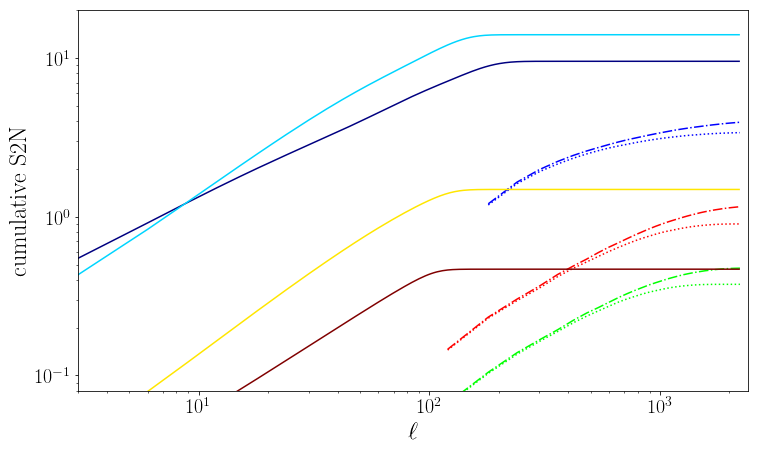

In [74]:
fig = P.figure(figsize = (12,7)); ax= fig.add_subplot(111);




ax.fill_between( np.array( [ellNL[0],ellNL[-1] ]), -10, 1000, color = 'grey', alpha = 0.4)


for i in range(nbinH):
    istart = np.where(HIRAX_cum[i] > 5e-2)[0][0]
    ci = color_array_HIRAX[i]
    zfmax_now = np.around(zHIRAX_highbin[i],2)
    zfmin_now = np.around(zHIRAX_lowbin[i],2)
    ax.loglog(ltabH[istart:], HIRAX_cum[i][istart:],
               label = r"$\mathrm{{~HIRAX~}} z_\mathrm{{f}} = {} \mathrm{{~to~}} {}$".format(zfmin_now, zfmax_now),
                 color=P.cm.brg(ci), ls = "-.")
    ax.loglog(ltabH[istart:], HIRAX512_cum[i][istart:], color=P.cm.brg(ci), ls = ":")

    
for i in range(nbinS):
    ci = color_array_SKA[i]
    zfmax_now = np.around(zSKA_highbin[i],2)
    zfmin_now = np.around(zSKA_lowbin[i],2)
    ax.loglog(ltabSKA, SKA_cum[i],
               label = r"$\mathrm{{~SKA~}} z_\mathrm{{f}} = {} \mathrm{{~to~}} {}$".format(zfmin_now, zfmax_now),
                 color=P.cm.jet(ci), ls = "-")


ax.set_xlabel(r"$\ell$")
ax.set_ylabel(r"$\mathrm{cumulative~S2N}$")
# ax.legend(loc = "upper left", fontsize = 20, frameon = False)
# ax.set_ylim((-1,180))
ax.set_ylim((8e-2,20))
# ax.set_xlim((3e0,ellNL[-2]))
ax.set_xlim((3e0,2.4e3))

# P.tight_layout()
# P.savefig(plotdir + "S2N_SKA_HIRAX_CUM.pdf")



# --Check the noise calculations!

To check the noise here are a few plots that show the different contributions:

In [75]:
#first make new zf:


zf = 1.1
dzf = 0.25
zmin = zf-dzf
zmax = zf+dzf



print "foreground from {} to {}".format(zf-dzf, zf+dzf)

ltabH = np.logspace(np.log10(lminHIRAX), np.log10(lend + lminHIRAX), 250, dtype = int)
ltabSKA = np.logspace(np.log10(lminSKA), np.log10(lend + lminSKA), 250, dtype = int)



foreground from 0.85 to 1.35


In [76]:
# optimize for HIRAX and SKA in these redshift bins:


ltab_SKA_fornoise_opt = np.array([100]) #only one ell for opt
ltab_H_fornoise_opt = np.array([200]) #only one ell for opt

opti_SKA_fornoise = []
opti_H_fornoise = []
guess_fornoise = 25

S2Nargs_SKA_fornoise = (ltab_SKA_fornoise_opt, zmin, zmax, buffer_z, [SKA, LSST], [C_l_HIHI_CAMB, C_l_gg_CAMB, Cl_HIxmag_CAMB])
opti_SKA_fornoise = optimize.minimize( S2N_for_opt, guess_fornoise, args = S2Nargs_SKA_fornoise, method='Nelder-Mead', tol = 1e-2, bounds = ((magmin,magmax),))

S2Nargs_H_fornoise = (ltab_H_fornoise_opt, zmin, zmax, buffer_z, [hirax, LSST], [C_l_HIHI_CAMB, C_l_gg_CAMB, Cl_HIxmag_CAMB])
opti_H_fornoise = optimize.minimize( S2N_for_opt, guess_fornoise, args = S2Nargs_H_fornoise, method='Nelder-Mead', tol = 1e-2, bounds = ((magmin,magmax),))

    
mso_SKA_fornoise = opti_SKA_fornoise['x'] #m star opt = mso
mso_H_fornoise = opti_H_fornoise['x'] #m star opt = mso


we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
we assume d_ell = 1
shot noise for LSST!
ca

In [77]:
print mso_H_fornoise, mso_SKA_fornoise

[23.3203125] [23.26171875]


In [78]:
#look at different error contributions

#get bg redshift:
zbmin_SKA_fornoise, zbmax_SKA_fornoise, zb_SKA_fornoise, dzb_SKA_fornoise = get_bg_bin_for_fgzmax(zmax, bufferz = buffer_z)
zbmin_H_fornoise, zbmax_H_fornoise, zb_H_fornoise, dzb_H_fornoise = get_bg_bin_for_fgzmax(zmax, bufferz = buffer_z)

print "SKA background from {} to {}".format(zbmin_SKA_fornoise, zbmax_SKA_fornoise)
print "HIRAX background from {} to {}".format(zbmin_H_fornoise, zbmax_H_fornoise)

powspeclist_SKA = [p_func_list[0](ltabSKA, zfmin, zfmax),
               p_func_list[1](ltabSKA, zbmin_SKA_fornoise, zbmax_SKA_fornoise, mso_SKA_fornoise),
               p_func_list[2](ltabSKA, zf, dzf, zb_SKA_fornoise, dzb_SKA_fornoise, MAXMAG = mso_SKA_fornoise)]

powspeclist_H = [p_func_list[0](ltabH, zfmin, zfmax),
               p_func_list[1](ltabH, zbmin_H_fornoise, zbmax_H_fornoise, mso_H_fornoise),
               p_func_list[2](ltabH, zf, dzf, zb_H_fornoise, dzb_H_fornoise, MAXMAG = mso_H_fornoise)]



#first get the 3 different signals:
#for HIRAX:
Xsignal_H = powspeclist_H[2]
hsignal_H = powspeclist_H[0]
gsignal_H = powspeclist_H[1]

# for SKA
Xsignal_S = powspeclist_SKA[2]
hsignal_S = powspeclist_SKA[0]
gsignal_S = powspeclist_SKA[1]

SKA background from 1.45 to 3.9
HIRAX background from 1.45 to 3.9


In [79]:
#now for CV
cverr_H = DELTA_Cl_HIxmag(ltabH, zf, dzf, zb_H_fornoise, dzb_H_fornoise, powspeclist_H, SURVEY = "CV", MAXMAG = mso_H_fornoise)
cverr_S = DELTA_Cl_HIxmag(ltabSKA, zf, dzf, zb_SKA_fornoise, dzb_SKA_fornoise, powspeclist_SKA, SURVEY = "CV", MAXMAG = mso_SKA_fornoise)
#for HIRAX
HIRAXerr = DELTA_Cl_HIxmag(ltabH, zf, dzf, zb_H_fornoise, dzb_H_fornoise, powspeclist_H, SURVEY = [hirax, LSST], MAXMAG = mso_H_fornoise)
#for SKA:
SKAerr = DELTA_Cl_HIxmag(ltabSKA, zf, dzf, zb_SKA_fornoise, dzb_SKA_fornoise, powspeclist_SKA, SURVEY = [SKA, LSST], MAXMAG = mso_SKA_fornoise)

#LSST shot noise:
LSSTshot_H = shotnoise(zb_H_fornoise, dzb_H_fornoise, LSST, NINT = 200, MAXMAG = mso_H_fornoise)
LSSTshot_S = shotnoise(zb_SKA_fornoise, dzb_SKA_fornoise, LSST, NINT = 200, MAXMAG = mso_SKA_fornoise)

#HIRAX N_ell
HIRAXNell = Cl_interferom_noise(ltabH,zfmin,zfmax, hirax)

#SKA N_ell
SKANell = noise_cls_single_dish(ltabSKA, ztonu21(zf), SKA, 256)

we assume d_ell = 1
we assume d_ell = 1
we assume d_ell = 1
shot noise for LSST!
calculating interferometer noise...
we assume d_ell = 1
shot noise for LSST!
calculating single dish autocorrelation noise
shot noise for LSST!
shot noise for LSST!


In [80]:
print "The error plots have redshifts {} to {} for foregrounds, and {} to {} for backgrounds.".format(zf-dzf, 
                                                                                                      zf+dzf,
                                                                                                     zb-dzb,
                                                                                                     zb+dzb)

The error plots have redshifts 0.85 to 1.35 for foregrounds, and 1.5 to 3.9 for backgrounds.


In [81]:
fsky_hirax = hirax["S_area"] /4/np.pi
fsky_SKA = SKA["S_area"] /4/np.pi


####cosmic variances:

SKACV_factor = np.sqrt(2)/np.sqrt((2*ltabSKA + 1) * fsky_SKA)
HIRAXCV_factor = np.sqrt(2)/np.sqrt((2*ltabH + 1) * fsky_hirax)
#cross:
XCVSKA = np.sqrt(Xsignal_S**2 + hsignal_S * gsignal_S) * SKACV_factor
XCVHIRAX = np.sqrt(Xsignal_H**2 + hsignal_H * gsignal_H) *HIRAXCV_factor
#HI:
HICVSKA = hsignal_S * SKACV_factor
HICVHIRAX = hsignal_H * HIRAXCV_factor
#gal:
GCVSKA = gsignal_S * SKACV_factor
GCVHIRAX = gsignal_H * HIRAXCV_factor

#noise contribution in the cross power spectrum:
XnoiseSKA = np.sqrt(hsignal_S*LSSTshot_S + gsignal_S*SKANell + LSSTshot_S*SKANell)
XnoiseHIRAX = np.sqrt(hsignal_H*LSSTshot_H + gsignal_H*HIRAXNell + LSSTshot_H*HIRAXNell)

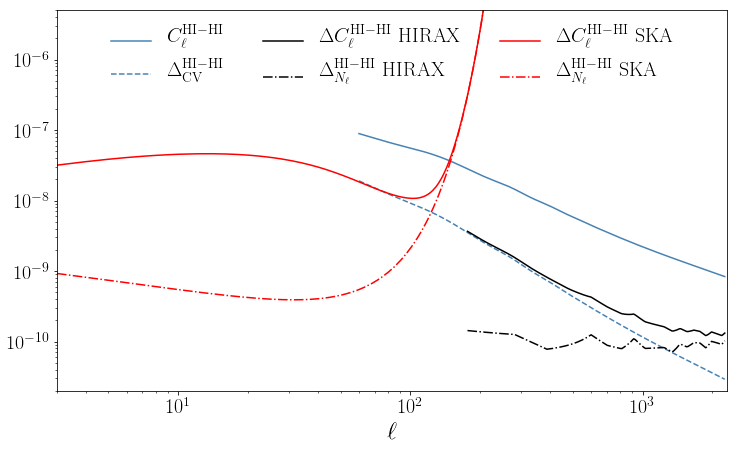

In [83]:
#first all for HI,HI power spectrum:
Hnoisecond = (HIRAXNell < 1e-3) 


fig = P.figure(figsize = (12,7)); ax = fig.add_subplot(111);
ax.loglog(ltabH, hsignal_H, label = r"$C_\ell^\mathrm{HI-HI}$", c = 'steelblue')
ax.loglog(ltabH, HICVHIRAX, label = r"$\Delta^\mathrm{HI-HI}_\mathrm{CV}$", color = 'steelblue', ls = "--")


ax.loglog(ltabH[Hnoisecond], (hsignal_H[Hnoisecond] + HIRAXNell[Hnoisecond]) * HIRAXCV_factor[Hnoisecond], label = r"$\Delta C_\ell^\mathrm{HI-HI} \mathrm{~HIRAX} $", color = "black")
ax.loglog(ltabH[Hnoisecond], HIRAXNell[Hnoisecond] * HIRAXCV_factor[Hnoisecond], label = r"$\Delta^\mathrm{HI-HI}_{N_\ell}\mathrm{~HIRAX}$", color = "black", ls = "-.")


ax.loglog(ltabSKA, (hsignal_S + SKANell) * SKACV_factor, label = r"$ \Delta C_\ell^\mathrm{HI-HI} \mathrm{~SKA}$", color = 'red')
ax.loglog(ltabSKA, SKANell * SKACV_factor, label = r"$\Delta^\mathrm{HI-HI}_{N_\ell} \mathrm{~SKA}$", color = "red", ls = "-.")
# ax.loglog(ltab, HICVSKA, label = r"$\Delta^\mathrm{HI-HI}_\mathrm{CV} \mathrm{~SKA}$", color = 'red', ls = "--")

ax.set_ylim((2e-11,5e-6))
ax.set_xlim((3e0, 2.3e3))

ax.set_xlabel(r"$\ell$")
P.legend(fontsize = 20, loc = "upper center", ncol=3, frameon = False)
# P.tight_layout()

# P.savefig(plotdir + "HIHI_error_contributions.pdf")

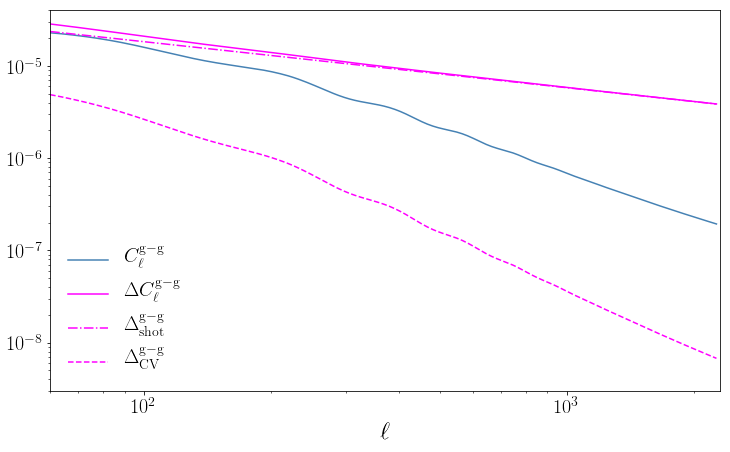

In [90]:
#now for galaxies:

fig = P.figure(figsize = (12,7)); ax = fig.add_subplot(111);
ax.loglog(ltabH, gsignal_H, label = r"$C_\ell^\mathrm{g-g}$", c= 'steelblue')

ax.loglog(ltabH, (gsignal_H + LSSTshot_H) * HIRAXCV_factor, label = r"$\Delta C_\ell^\mathrm{g-g}$", color = "magenta")
ax.loglog(ltabH, LSSTshot_H * HIRAXCV_factor, label = r" $\Delta^\mathrm{g-g}_\mathrm{shot}$", color = "magenta", ls = "-.")
ax.loglog(ltabH, GCVHIRAX, label = r"$\Delta^\mathrm{g-g}_\mathrm{CV}$", color = 'magenta', ls = "--")


# ax.loglog(ltab, gsignal_S, label = r"$C_\ell^\mathrm{g-g}$")

# ax.loglog(ltab, (gsignal_S + LSSTshot_S) * SKACV_factor, label = r"$\Delta C_\ell^\mathrm{g-g}$", color = "cyan")
# ax.loglog(ltab, LSSTshot_S * SKACV_factor, label = r" $\Delta^\mathrm{g-g}_\mathrm{shot}$", color = "cyan", ls = "-.")
# ax.loglog(ltab, GCVSKA, label = r"$\Delta^\mathrm{g-g}_\mathrm{CV}$", color = 'cyan', ls = "--")



ax.set_xlim((lminHIRAX,2.3e3))
ax.set_ylim((3e-9, 4e-5))
ax.set_xlabel(r"$\ell$")
P.legend(loc = "lower left", fontsize = 20, frameon = False)
# P.tight_layout()

# P.savefig(plotdir + "GG_error_contributions.pdf")

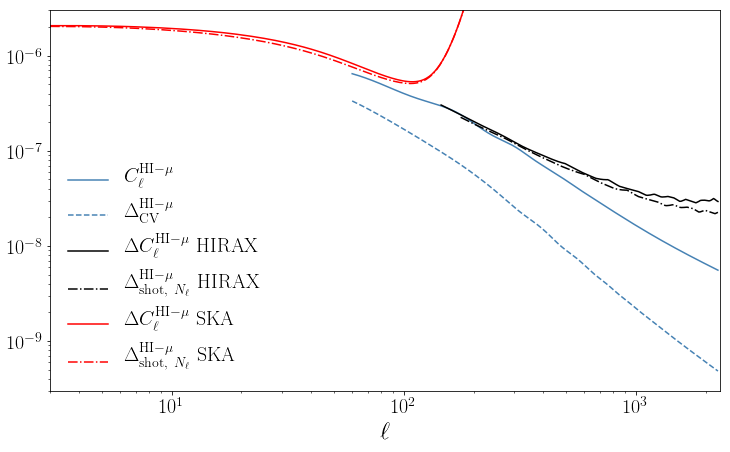

In [95]:
#last but not least the HIxmag power spectrum:

Hnoisecond = (HIRAXerr < 1e-3) 
Hnoisecond2 = (XnoiseHIRAX < 1e-3)

fig = P.figure(figsize = (12,7)); ax = fig.add_subplot(111);
ax.loglog(ltabH, Xsignal_H, label = r"$C_\ell^{\mathrm{HI-}\mu}$", color = 'steelblue')
ax.loglog(ltabH, XCVHIRAX, label = r"$\Delta_\mathrm{CV}^{\mathrm{HI-} \mu} $", color = 'steelblue', ls = "--")

# ax.loglog(ltab, Xsignal_S, color = 'blue')
# ax.fill_between(ltab, Xsignal_H, Xsignal_S, color= 'blue', alpha = 0.2)

ax.loglog(ltabH[Hnoisecond], HIRAXerr[Hnoisecond], label = r"$\Delta C_\ell^{\mathrm{HI-} \mu} \mathrm{~HIRAX} $", color = "black")
ax.loglog(ltabH[Hnoisecond2], XnoiseHIRAX[Hnoisecond2] * HIRAXCV_factor[Hnoisecond2], label = r"$\Delta^{\mathrm{HI-} \mu}_{\mathrm{shot,~}N_\ell} \mathrm{~HIRAX}$", color = "black", ls = "-.")


ax.loglog(ltabSKA, SKAerr, label = r"$\Delta C_\ell^{\mathrm{HI-} \mu} \mathrm{~SKA} $", color = 'red')
ax.loglog(ltabSKA, XnoiseSKA * SKACV_factor, label = r"$\Delta^{\mathrm{HI-} \mu}_{\mathrm{shot,~}N_\ell} \mathrm{~SKA}$", color = "red", ls = "-.")
# ax.loglog(ltab, XCVSKA, label = r"$\Delta_\mathrm{CV}^{\mathrm{HI-} \mu} \mathrm{~SKA} $", color = 'red', ls = "--")

ax.set_xlabel(r"$\ell$")
P.legend(fontsize = 20, loc = "lower left", frameon = False)
ax.set_ylim((3e-10,3e-6))
ax.set_xlim((3e0, 2.3e3))

# P.tight_layout()
P.savefig(plotdir + "X_error_contributions.pdf")